In [1]:
from pymongo import MongoClient
import pprint

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

import json
import time
import copy

In [47]:
#Import URLs
off_the_tee_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02567.y2019.html'
approach_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02568.y2019.html'
around_the_green_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02569.y2019.html'
putting_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02564.y2019.html'
total_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02675.y2020.html'

In [48]:
#Request HTML
tee = requests.get(off_the_tee_url)
med_long = requests.get(approach_url)
med_short = requests.get(around_the_green_url)
putt = requests.get(putting_url)
total = requests.get(total_url)

In [49]:
#Check status == 200 :: 200 implies the request was successfully processed
requested = [tee, med_short, med_long, putt, total]
for r in requested:
    print(r.status_code)

200
200
200
200
200


In [50]:
#Print sample HTML from each request
for r in requested:
    pprint.pprint(r.text[:1000])

('\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '<!DOCTYPE HTML>\n'
 '<html lang="en" >\n'
 '\n'
 '    \n'
 '    \n'
 '        <head>\n'
 '    <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n'
 '    <meta name="viewport" content="width=device-width, initial-scale=1.0, '
 'maximum-scale=1.0, user-scalable=no, shrink-to-fit=no" />\n'
 '\n'
 '    <link rel="canonical" '
 'href="https://www.pgatour.com/stats/stat.02567.y2019.html"/>\n'
 '<meta name="title" content="SG: Off-the-Tee | PGA TOUR Stats" />\n'
 '<meta name="description" content="Strokes Gained | Distance (All Drives) | '
 'Distance (Measured Drives) | Accuracy | Scoring | Other | Radar" />\n'
 '<meta name="msApplication-ID" content="pga-tour/9wzdncrfhz2c"/>\n'
 '\n'
 '<meta name="google-site-verification" '
 'content="xp_dFTcmlaq2Fgq3gyZfIjWo0KjdEC4cfaO4nWx5yPA" />\n'
 '<!-- Google Authorship and Publisher Markup -->\n'
 '<!-- Schema.org markup for Google+ http://schema.org/Article -->\n'
 '<meta itemprop="name" conten

In [51]:
#Save HTML into a MongoDB
client = MongoClient()
golf_db = client.golf
long_html = golf_db.long
med_long_html = golf_db.med_long
med_short_html = golf_db.med_short
short_html = golf_db.short
total_html = golf_db.total

long_html.insert_one({'link': off_the_tee_url, 'html': tee.text})
med_long_html.insert_one({'link': approach_url, 'html': med_long.text})
med_short_html.insert_one({'link': around_the_green_url, 'html': med_short.text})
short_html.insert_one({'link': putting_url, 'html': putt.text})
total_html.insert_one({'link': total_url, 'html': total.text})
client.list_database_names()

['admin', 'config', 'golf', 'local']

In [52]:
#Parse HTML
soup_tee = BeautifulSoup(tee.text, 'html.parser')
soup_med_long = BeautifulSoup(med_long.text, 'html.parser')
soup_med_short = BeautifulSoup(med_short.text, 'html.parser')
soup_putt = BeautifulSoup(putt.text, 'html.parser')
soup_total = BeautifulSoup(total.text, 'html.parser')

In [53]:
#Search HTML for table
soup_tee.find_all('table')

[<table>
 <tr>
 <td><span class="icon-alert"></span></td>
 <td>
 <p>It appears your browser may be outdated. For the best website experience, we recommend updating your browser. 
                             
                                 <a class="message-button" href="http://windows.microsoft.com/en-us/internet-explorer/download-ie">
                                     learn more</a>
 </p>
 </td>
 <td><span class="close-message"></span></td>
 </tr>
 </table>,
 <table class="table-styled" id="statsTable">
 <thead>
 <tr>
 <th class="rank-this">RANK <span class="hidden-small hidden-medium">THIS WEEK</span></th>
 <th class="rank-last hidden-print hidden-small hidden-medium">
                                 RANK LAST WEEK</th>
 <th class="player-name">PLAYER NAME</th>
 <th class="rounds hidden-small hidden-medium">ROUNDS</th>
 <th class="col-stat">AVERAGE</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:OTT</th>
 <th class="col-stat hidden-small hidden-medium">MEASURED 

In [54]:
soup_med_long.find_all('table')

[<table>
 <tr>
 <td><span class="icon-alert"></span></td>
 <td>
 <p>It appears your browser may be outdated. For the best website experience, we recommend updating your browser. 
                             
                                 <a class="message-button" href="http://windows.microsoft.com/en-us/internet-explorer/download-ie">
                                     learn more</a>
 </p>
 </td>
 <td><span class="close-message"></span></td>
 </tr>
 </table>,
 <table class="table-styled" id="statsTable">
 <thead>
 <tr>
 <th class="rank-this">RANK <span class="hidden-small hidden-medium">THIS WEEK</span></th>
 <th class="rank-last hidden-print hidden-small hidden-medium">
                                 RANK LAST WEEK</th>
 <th class="player-name">PLAYER NAME</th>
 <th class="rounds hidden-small hidden-medium">ROUNDS</th>
 <th class="col-stat">AVERAGE</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:APP</th>
 <th class="col-stat hidden-small hidden-medium">MEASURED 

In [55]:
soup_med_short.find_all('table')

[<table>
 <tr>
 <td><span class="icon-alert"></span></td>
 <td>
 <p>It appears your browser may be outdated. For the best website experience, we recommend updating your browser. 
                             
                                 <a class="message-button" href="http://windows.microsoft.com/en-us/internet-explorer/download-ie">
                                     learn more</a>
 </p>
 </td>
 <td><span class="close-message"></span></td>
 </tr>
 </table>,
 <table class="table-styled" id="statsTable">
 <thead>
 <tr>
 <th class="rank-this">RANK <span class="hidden-small hidden-medium">THIS WEEK</span></th>
 <th class="rank-last hidden-print hidden-small hidden-medium">
                                 RANK LAST WEEK</th>
 <th class="player-name">PLAYER NAME</th>
 <th class="rounds hidden-small hidden-medium">ROUNDS</th>
 <th class="col-stat">AVERAGE</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:ARG</th>
 <th class="col-stat hidden-small hidden-medium">MEASURED 

In [56]:
soup_putt.find_all('table')

[<table>
 <tr>
 <td><span class="icon-alert"></span></td>
 <td>
 <p>It appears your browser may be outdated. For the best website experience, we recommend updating your browser. 
                             
                                 <a class="message-button" href="http://windows.microsoft.com/en-us/internet-explorer/download-ie">
                                     learn more</a>
 </p>
 </td>
 <td><span class="close-message"></span></td>
 </tr>
 </table>,
 <table class="table-styled" id="statsTable">
 <thead>
 <tr>
 <th class="rank-this">RANK <span class="hidden-small hidden-medium">THIS WEEK</span></th>
 <th class="rank-last hidden-print hidden-small hidden-medium">
                                 RANK LAST WEEK</th>
 <th class="player-name">PLAYER NAME</th>
 <th class="rounds hidden-small hidden-medium">ROUNDS</th>
 <th class="col-stat">AVERAGE</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:PUTTING</th>
 <th class="col-stat hidden-small hidden-medium">MEASU

In [57]:
soup_total.find_all('table')

[<table>
 <tr>
 <td><span class="icon-alert"></span></td>
 <td>
 <p>It appears your browser may be outdated. For the best website experience, we recommend updating your browser. 
                             
                                 <a class="message-button" href="http://windows.microsoft.com/en-us/internet-explorer/download-ie">
                                     learn more</a>
 </p>
 </td>
 <td><span class="close-message"></span></td>
 </tr>
 </table>,
 <table class="table-styled" id="statsTable">
 <thead>
 <tr>
 <th class="rank-this">RANK <span class="hidden-small hidden-medium">THIS WEEK</span></th>
 <th class="rank-last hidden-print hidden-small hidden-medium">
                                 RANK LAST WEEK</th>
 <th class="player-name">PLAYER NAME</th>
 <th class="rounds hidden-small hidden-medium">ROUNDS</th>
 <th class="col-stat">AVERAGE</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:T</th>
 <th class="col-stat hidden-small hidden-medium">TOTAL SG:T2

In [41]:
#All tables have class attribute 'table-styled'
#Functionalize getting data from each
def get_list_from_soup(soup_object):
    data = []
    table = soup_object.find('table', attrs={'class':'table-styled'})
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
        
    return data

In [58]:
#Plug soup objects into function above
tee_data = get_list_from_soup(soup_tee)
approach_data = get_list_from_soup(soup_med_long)
chip_data = get_list_from_soup(soup_med_short)
putt_data = get_list_from_soup(soup_putt)
total_data = get_list_from_soup(soup_total)

In [43]:
tee_data

[['1', '1', 'Rory McIlroy', '72', '1.195', '68.124', '57'],
 ['2', '3', 'Jhonattan Vegas', '75', '.753', '45.956', '61'],
 ['3', '4', 'Bubba Watson', '65', '.743', '37.171', '50'],
 ['4', '5', 'Dustin Johnson', '73', '.703', '39.360', '56'],
 ['5', '2', 'Jon Rahm', '75', '.692', '36.684', '53'],
 ['T6', 'T6', 'Keith Mitchell', '86', '.657', '40.068', '61'],
 ['T6', 'T6', 'Cameron Champ', '78', '.657', '44.682', '68'],
 ['8', '8', 'Corey Conners', '90', '.653', '45.081', '69'],
 ['9', '9', 'Paul Casey', '79', '.614', '33.761', '55'],
 ['10', '10', 'Abraham Ancer', '93', '.575', '40.830', '71'],
 ['11', '11', 'Jason Kokrak', '94', '.550', '41.269', '75'],
 ['12', '12', 'Tommy Fleetwood', '71', '.545', '27.235', '50'],
 ['13', '14', 'Jason Day', '69', '.535', '25.143', '47'],
 ['14', '15', 'Aaron Wise', '72', '.533', '28.799', '54'],
 ['15', '18', 'Brendan Steele', '68', '.518', '26.393', '51'],
 ['16', '20', 'Luke List', '66', '.481', '26.461', '55'],
 ['17', '24', 'Justin Thomas', '75',

In [44]:
approach_data

[['1', '1', 'Henrik Stenson', '58', '1.149', '48.250', '42'],
 ['2', '2', 'Justin Thomas', '75', '.985', '55.176', '56'],
 ['3', '3', 'Emiliano Grillo', '85', '.926', '50.929', '55'],
 ['4', '4', 'Adam Scott', '63', '.846', '37.234', '44'],
 ['5', '5', 'Hideki Matsuyama', '91', '.759', '55.397', '73'],
 ['6', '7', 'Jason Kokrak', '94', '.745', '55.838', '75'],
 ['7', '6', 'Jim Furyk', '73', '.741', '42.250', '57'],
 ['8', '9', 'Paul Casey', '79', '.706', '38.844', '55'],
 ['9', '10', 'Corey Conners', '90', '.665', '45.915', '69'],
 ['10', '12', 'Patrick Cantlay', '77', '.640', '36.474', '57'],
 ['11', '16', 'Brooks Koepka', '81', '.636', '36.896', '58'],
 ['12', '13', 'Rory McIlroy', '72', '.633', '36.096', '57'],
 ['13', '17', 'Chez Reavie', '99', '.625', '43.753', '70'],
 ['14', '11', 'Webb Simpson', '81', '.613', '42.285', '69'],
 ['15', '14', 'Talor Gooch', '54', '.604', '28.977', '48'],
 ['16', '15', 'Ryan Moore', '74', '.596', '37.519', '63'],
 ['17', '8', 'Matt Kuchar', '87', '.

In [45]:
chip_data

[['1', '1', 'Byeong Hun An', '80', '.631', '38.504', '61'],
 ['2', '2', 'Bud Cauley', '82', '.577', '42.673', '74'],
 ['3', '3', 'Brandt Snedeker', '102', '.480', '38.408', '80'],
 ['4', '4', 'Aaron Baddeley', '55', '.460', '19.309', '42'],
 ['5', '8', 'Stephan Jaeger', '77', '.365', '20.783', '57'],
 ['6', '6', 'Patrick Cantlay', '77', '.356', '20.291', '57'],
 ['7', '10', 'Kevin Na', '65', '.355', '15.617', '44'],
 ['T8', '11', 'Matt Jones', '88', '.352', '23.225', '66'],
 ['T8', 'T19', 'Justin Thomas', '75', '.352', '19.729', '56'],
 ['10', '5', 'Adam Scott', '63', '.351', '15.457', '44'],
 ['11', '12', 'Bill Haas', '77', '.350', '21.342', '61'],
 ['12', '13', 'Hideki Matsuyama', '91', '.347', '25.337', '73'],
 ['13', '14', 'Pat Perez', '68', '.335', '13.736', '41'],
 ['14', '15', 'Patrick Reed', '93', '.332', '24.253', '73'],
 ['15', 'T19', 'Tommy Fleetwood', '71', '.329', '16.466', '50'],
 ['16', '7', 'Charles Howell III', '94', '.328', '23.940', '73'],
 ['17', '17', 'Jimmy Walker

In [46]:
putt_data

[['1', '1', 'Denny McCarthy', '89', '.926', '63.890', '69'],
 ['2', '2', 'Jordan Spieth', '82', '.862', '56.900', '66'],
 ['3', '3', 'Dominic Bozzelli', '73', '.847', '41.522', '49'],
 ['4', '4', 'Graeme McDowell', '75', '.731', '36.555', '50'],
 ['5', '5', 'Andrew Putnam', '81', '.700', '39.180', '56'],
 ['6', '8', 'Aaron Baddeley', '55', '.654', '27.451', '42'],
 ['7', '9', 'Patton Kizzire', '76', '.642', '34.050', '53'],
 ['8', '10', 'Wyndham Clark', '87', '.640', '46.752', '73'],
 ['9', '11', 'Vaughn Taylor', '93', '.636', '52.113', '82'],
 ['10', '12', 'Beau Hossler', '87', '.619', '42.084', '68'],
 ['11', '13', 'Webb Simpson', '81', '.608', '41.957', '69'],
 ['12', '6', 'Brandt Snedeker', '102', '.592', '47.330', '80'],
 ['13', '18', 'Rickie Fowler', '76', '.541', '34.066', '63'],
 ['14', '15', 'Pat Perez', '68', '.535', '21.954', '41'],
 ['15', '16', 'Harris English', '97', '.527', '41.671', '79'],
 ['16', '17', 'Billy Horschel', '99', '.522', '36.051', '69'],
 ['17', '7', 'Just

In [59]:
total_data

[['1', '1', 'Jon Rahm', '58', '1.823', '103.920', '76.597', '27.326', '57'],
 ['2',
  '4',
  'Justin Thomas',
  '66',
  '1.709',
  '99.147',
  '100.966',
  '-1.816',
  '58'],
 ['3',
  '7',
  'Xander Schauffele',
  '70',
  '1.605',
  '97.935',
  '75.582',
  '22.355',
  '61'],
 ['4', '3', 'Webb Simpson', '52', '1.597', '81.422', '51.369', '30.056', '51'],
 ['5',
  '2',
  'Bryson DeChambeau',
  '62',
  '1.566',
  '97.074',
  '56.300',
  '40.776',
  '62'],
 ['6',
  '5',
  'Daniel Berger',
  '64',
  '1.560',
  '87.337',
  '57.892',
  '29.450',
  '56'],
 ['7',
  '6',
  'Harris English',
  '76',
  '1.467',
  '99.728',
  '64.479',
  '35.253',
  '68'],
 ['8',
  '8',
  'Tyrrell Hatton',
  '42',
  '1.431',
  '48.637',
  '36.234',
  '12.403',
  '34'],
 ['9',
  '9',
  'Dustin Johnson',
  '49',
  '1.409',
  '66.209',
  '53.489',
  '12.722',
  '47'],
 ['10',
  '12',
  'Patrick Cantlay',
  '46',
  '1.316',
  '57.911',
  '48.274',
  '9.642',
  '44'],
 ['11',
  '11',
  'Patrick Reed',
  '74',
  '1.295',

In [64]:
tee_trimmed = [[x[0], x[2], x[4]] for x in tee_data]
approach_trimmed = [[x[0], x[2], x[4]] for x in approach_data]
chip_trimmed = [[x[0], x[2], x[4]] for x in chip_data]
putt_trimmed = [[x[0], x[2], x[4]] for x in putt_data]

In [65]:
tee_trimmed

[['1', 'Rory McIlroy', '1.195'],
 ['2', 'Jhonattan Vegas', '.753'],
 ['3', 'Bubba Watson', '.743'],
 ['4', 'Dustin Johnson', '.703'],
 ['5', 'Jon Rahm', '.692'],
 ['T6', 'Keith Mitchell', '.657'],
 ['T6', 'Cameron Champ', '.657'],
 ['8', 'Corey Conners', '.653'],
 ['9', 'Paul Casey', '.614'],
 ['10', 'Abraham Ancer', '.575'],
 ['11', 'Jason Kokrak', '.550'],
 ['12', 'Tommy Fleetwood', '.545'],
 ['13', 'Jason Day', '.535'],
 ['14', 'Aaron Wise', '.533'],
 ['15', 'Brendan Steele', '.518'],
 ['16', 'Luke List', '.481'],
 ['17', 'Justin Thomas', '.479'],
 ['18', 'Patrick Cantlay', '.475'],
 ['19', 'Gary Woodland', '.472'],
 ['20', 'Emiliano Grillo', '.470'],
 ['21', 'Brooks Koepka', '.468'],
 ['22', 'Xander Schauffele', '.456'],
 ['23', 'Tony Finau', '.439'],
 ['24', 'Bryson DeChambeau', '.421'],
 ['25', 'Kevin Streelman', '.383'],
 ['26', 'Hideki Matsuyama', '.381'],
 ['27', 'Alex Prugh', '.379'],
 ['28', 'Sepp Straka', '.378'],
 ['29', 'Byeong Hun An', '.351'],
 ['30', 'Sergio Garcia', '

In [66]:
approach_trimmed

[['1', 'Henrik Stenson', '1.149'],
 ['2', 'Justin Thomas', '.985'],
 ['3', 'Emiliano Grillo', '.926'],
 ['4', 'Adam Scott', '.846'],
 ['5', 'Hideki Matsuyama', '.759'],
 ['6', 'Jason Kokrak', '.745'],
 ['7', 'Jim Furyk', '.741'],
 ['8', 'Paul Casey', '.706'],
 ['9', 'Corey Conners', '.665'],
 ['10', 'Patrick Cantlay', '.640'],
 ['11', 'Brooks Koepka', '.636'],
 ['12', 'Rory McIlroy', '.633'],
 ['13', 'Chez Reavie', '.625'],
 ['14', 'Webb Simpson', '.613'],
 ['15', 'Talor Gooch', '.604'],
 ['16', 'Ryan Moore', '.596'],
 ['17', 'Matt Kuchar', '.591'],
 ['18', 'Russell Knox', '.585'],
 ['19', 'Keegan Bradley', '.567'],
 ['20', 'Gary Woodland', '.545'],
 ['T21', 'Sergio Garcia', '.525'],
 ['T21', 'Justin Rose', '.525'],
 ['23', 'Adam Svensson', '.509'],
 ['24', 'Nate Lashley', '.487'],
 ['25', 'Joaquin Niemann', '.484'],
 ['26', 'Xander Schauffele', '.481'],
 ['27', 'Kevin Streelman', '.479'],
 ['28', 'Marc Leishman', '.472'],
 ['29', 'Roberto Castro', '.432'],
 ['30', 'Shawn Stefani', '.4

In [67]:
chip_trimmed

[['1', 'Byeong Hun An', '.631'],
 ['2', 'Bud Cauley', '.577'],
 ['3', 'Brandt Snedeker', '.480'],
 ['4', 'Aaron Baddeley', '.460'],
 ['5', 'Stephan Jaeger', '.365'],
 ['6', 'Patrick Cantlay', '.356'],
 ['7', 'Kevin Na', '.355'],
 ['T8', 'Matt Jones', '.352'],
 ['T8', 'Justin Thomas', '.352'],
 ['10', 'Adam Scott', '.351'],
 ['11', 'Bill Haas', '.350'],
 ['12', 'Hideki Matsuyama', '.347'],
 ['13', 'Pat Perez', '.335'],
 ['14', 'Patrick Reed', '.332'],
 ['15', 'Tommy Fleetwood', '.329'],
 ['16', 'Charles Howell III', '.328'],
 ['17', 'Jimmy Walker', '.322'],
 ['18', 'Si Woo Kim', '.305'],
 ['19', 'Rory McIlroy', '.297'],
 ['20', 'Webb Simpson', '.294'],
 ['T21', 'Tyrrell Hatton', '.286'],
 ['T21', 'Cameron Smith', '.286'],
 ['23', 'Sungjae Im', '.285'],
 ['24', 'Ernie Els', '.282'],
 ['25', 'Alex Noren', '.280'],
 ['T26', 'Rod Pampling', '.278'],
 ['T26', 'Branden Grace', '.278'],
 ['28', 'Louis Oosthuizen', '.270'],
 ['29', 'Ian Poulter', '.267'],
 ['30', 'Rory Sabbatini', '.263'],
 ['T

In [68]:
putt_trimmed

[['1', 'Denny McCarthy', '.926'],
 ['2', 'Jordan Spieth', '.862'],
 ['3', 'Dominic Bozzelli', '.847'],
 ['4', 'Graeme McDowell', '.731'],
 ['5', 'Andrew Putnam', '.700'],
 ['6', 'Aaron Baddeley', '.654'],
 ['7', 'Patton Kizzire', '.642'],
 ['8', 'Wyndham Clark', '.640'],
 ['9', 'Vaughn Taylor', '.636'],
 ['10', 'Beau Hossler', '.619'],
 ['11', 'Webb Simpson', '.608'],
 ['12', 'Brandt Snedeker', '.592'],
 ['13', 'Rickie Fowler', '.541'],
 ['14', 'Pat Perez', '.535'],
 ['15', 'Harris English', '.527'],
 ['16', 'Billy Horschel', '.522'],
 ['17', 'Justin Rose', '.504'],
 ['18', 'Johnson Wagner', '.488'],
 ['19', 'Peter Malnati', '.467'],
 ['20', 'Kevin Kisner', '.450'],
 ['21', 'Curtis Luck', '.446'],
 ['22', 'Patrick Rodgers', '.428'],
 ['23', 'Sam Ryder', '.427'],
 ['T24', 'Rory McIlroy', '.425'],
 ['T24', 'Ian Poulter', '.425'],
 ['26', 'Patrick Cantlay', '.386'],
 ['27', 'Chase Wright', '.379'],
 ['28', 'Bryson DeChambeau', '.372'],
 ['29', 'Sam Burns', '.369'],
 ['30', 'Jason Day', '.

In [71]:
print(f'{len(tee_trimmed)} values in tee')
print(f'{len(approach_trimmed)} values in approach')
print(f'{len(chip_trimmed)} values in chip')
print(f'{len(putt_trimmed)} values in putt')

188 values in tee
188 values in approach
188 values in chip
188 values in putt


In [88]:
tee_df = pd.DataFrame(tee_trimmed, columns = ['tee_rank', 'name', 'tee_strokes_gained'])
tee_df

,tee_rank,name,tee_strokes_gained
0,1,Rory McIlroy,1.195
1,2,Jhonattan Vegas,.753
2,3,Bubba Watson,.743
3,4,Dustin Johnson,.703
4,5,Jon Rahm,.692
...,...,...,...
183,T184,Andrew Putnam,-.639
184,T184,Freddie Jacobson,-.639
185,186,Jonathan Byrd,-.758
186,187,Whee Kim,-1.035


In [87]:
approach_df = pd.DataFrame(approach_trimmed, columns = ['approach_rank', 'name', 'approach_strokes_gained'])
approach_df

,approach_rank,name,approach_strokes_gained
0,1,Henrik Stenson,1.149
1,2,Justin Thomas,.985
2,3,Emiliano Grillo,.926
3,4,Adam Scott,.846
4,5,Hideki Matsuyama,.759
...,...,...,...
183,184,Beau Hossler,-.765
184,185,Dominic Bozzelli,-.766
185,186,Curtis Luck,-.847
186,187,Seth Reeves,-.941


In [86]:
chip_df = pd.DataFrame(chip_trimmed, columns = ['chip_rank', 'name', 'chip_strokes_gained'])
chip_df

,chip_rank,name,chip_strokes_gained
0,1,Byeong Hun An,.631
1,2,Bud Cauley,.577
2,3,Brandt Snedeker,.480
3,4,Aaron Baddeley,.460
4,5,Stephan Jaeger,.365
...,...,...,...
183,T183,Seth Reeves,-.366
184,185,Austin Cook,-.372
185,186,Satoshi Kodaira,-.414
186,187,Hunter Mahan,-.574


In [85]:
putt_df = pd.DataFrame(putt_trimmed, columns = ['putt_rank', 'name', 'putt_strokes_gained'])
putt_df

,putt_rank,name,putt_strokes_gained
0,1,Denny McCarthy,.926
1,2,Jordan Spieth,.862
2,3,Dominic Bozzelli,.847
3,4,Graeme McDowell,.731
4,5,Andrew Putnam,.700
...,...,...,...
183,184,Kramer Hickok,-.604
184,185,Emiliano Grillo,-.633
185,186,J.J. Henry,-.657
186,187,J.B. Holmes,-.752


In [89]:
#Merge DataFrames
golf_df = pd.merge(tee_df, approach_df, how = 'left', on = 'name')
golf_df = pd.merge(golf_df, chip_df, how = 'left', on = 'name')
golf_df = pd.merge(golf_df, putt_df, how = 'left', on = 'name')
golf_df

,tee_rank,name,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained
0,1,Rory McIlroy,1.195,12,.633,19,.297,T24,.425
1,2,Jhonattan Vegas,.753,60,.219,154,-.190,135,-.156
2,3,Bubba Watson,.743,120,-.052,124,-.067,T167,-.344
3,4,Dustin Johnson,.703,47,.288,38,.234,74,.096
4,5,Jon Rahm,.692,34,.405,78,.073,36,.336
...,...,...,...,...,...,...,...,...,...
183,T184,Andrew Putnam,-.639,32,.414,83,.061,5,.700
184,T184,Freddie Jacobson,-.639,138,-.151,152,-.178,64,.142
185,186,Jonathan Byrd,-.758,63,.204,41,.205,171,-.412
186,187,Whee Kim,-1.035,146,-.217,T129,-.080,92,.042


In [92]:
#Rearrange columns
cols = golf_df.columns.tolist()
cols = [cols[1],cols[0]] + cols[2:]
golf_df = golf_df[cols]
golf_df

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained
0,Rory McIlroy,1,1.195,12,.633,19,.297,T24,.425
1,Jhonattan Vegas,2,.753,60,.219,154,-.190,135,-.156
2,Bubba Watson,3,.743,120,-.052,124,-.067,T167,-.344
3,Dustin Johnson,4,.703,47,.288,38,.234,74,.096
4,Jon Rahm,5,.692,34,.405,78,.073,36,.336
...,...,...,...,...,...,...,...,...,...
183,Andrew Putnam,T184,-.639,32,.414,83,.061,5,.700
184,Freddie Jacobson,T184,-.639,138,-.151,152,-.178,64,.142
185,Jonathan Byrd,186,-.758,63,.204,41,.205,171,-.412
186,Whee Kim,187,-1.035,146,-.217,T129,-.080,92,.042


In [94]:
golf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   name                     188 non-null    object
 1   tee_rank                 188 non-null    object
 2   tee_strokes_gained       188 non-null    object
 3   approach_rank            188 non-null    object
 4   approach_strokes_gained  188 non-null    object
 5   chip_rank                188 non-null    object
 6   chip_strokes_gained      188 non-null    object
 7   putt_rank                188 non-null    object
 8   putt_strokes_gained      188 non-null    object
dtypes: object(9)
memory usage: 14.7+ KB


In [98]:
#Strip rankings of T in ties
rankings = ['tee_rank', 'approach_rank', 'chip_rank', 'putt_rank']
for series in rankings:
    for string in series:
        golf_df[series] = golf_df[series].str.replace('T','')

In [99]:
golf_df

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained
0,Rory McIlroy,1,1.195,12,.633,19,.297,24,.425
1,Jhonattan Vegas,2,.753,60,.219,154,-.190,135,-.156
2,Bubba Watson,3,.743,120,-.052,124,-.067,167,-.344
3,Dustin Johnson,4,.703,47,.288,38,.234,74,.096
4,Jon Rahm,5,.692,34,.405,78,.073,36,.336
...,...,...,...,...,...,...,...,...,...
183,Andrew Putnam,184,-.639,32,.414,83,.061,5,.700
184,Freddie Jacobson,184,-.639,138,-.151,152,-.178,64,.142
185,Jonathan Byrd,186,-.758,63,.204,41,.205,171,-.412
186,Whee Kim,187,-1.035,146,-.217,129,-.080,92,.042


In [108]:
columns_sans_name = golf_df.columns.tolist()[1:]
for col in columns_sans_name:
    golf_df[col] = pd.to_numeric(golf_df[col])
golf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     188 non-null    object 
 1   tee_rank                 188 non-null    int64  
 2   tee_strokes_gained       188 non-null    float64
 3   approach_rank            188 non-null    int64  
 4   approach_strokes_gained  188 non-null    float64
 5   chip_rank                188 non-null    int64  
 6   chip_strokes_gained      188 non-null    float64
 7   putt_rank                188 non-null    int64  
 8   putt_strokes_gained      188 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 14.7+ KB


In [110]:
bins = 187 ** .5
print(bins)

13.674794331177344


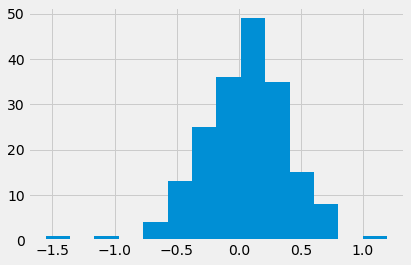

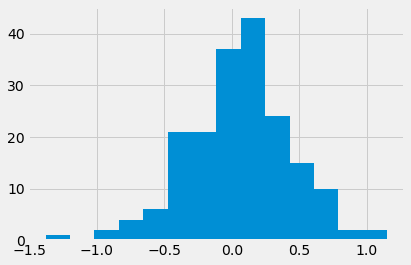

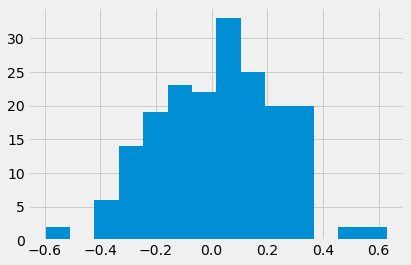

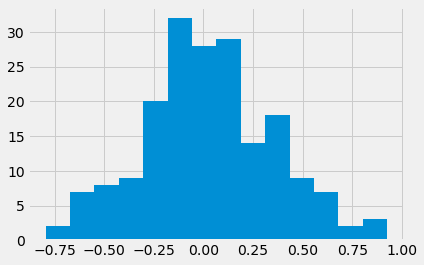

In [111]:
strokes_gained_columns = [golf_df.tee_strokes_gained, golf_df.approach_strokes_gained, golf_df.chip_strokes_gained, golf_df.putt_strokes_gained]

for series in strokes_gained_columns:
    fig, ax = plt.subplots()
    ax.hist(series, 14)